# Start by reproducing previous results in a single example

(Huang, Chang 2025 Causality  $\ne$ Decodability)

- CLS token decodability by linear probing increases in the middle of the network, while causality remains low.
- 

(Vilas et al 2023 Analyzing Vision Transformers for Image Classification in Class Embedding Space)

- Using the classification read-out as a probe, shows high identifiability score based on relative position of the ground-truth logit




In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch

In [2]:
from initialization import setup_model_ds_collator_images
from training import run_probe_training

model_name = "google/vit-base-patch16-224"
dataset_name = "zh-plus/tiny-imagenet"

W0108 19:10:52.251000 22875 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
_, ds, collator = setup_model_ds_collator_images('google/vit-base-patch16-224', dataset_name)
ds['test'] = ds['valid']

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import AutoModelForImageClassification
model = AutoModelForImageClassification.from_pretrained('test/probe/checkpoint-1563/')
model = model.eval().to('mps')

In [5]:
from analysis import run_across_layers, apply_model_decoder, accuracy_random_CLS, linear_probe_by_ridge_regression

## Identifiability across layers

Using the output probing and identifiability metrics from (Vilas et al 2023)

In [6]:
identifiabilityResults = run_across_layers(model, ds, apply_model_decoder, 'vit.encoder.layer.{ind}', 12)

100%|███████████████████████████████████████████| 79/79 [01:03<00:00,  1.24it/s]


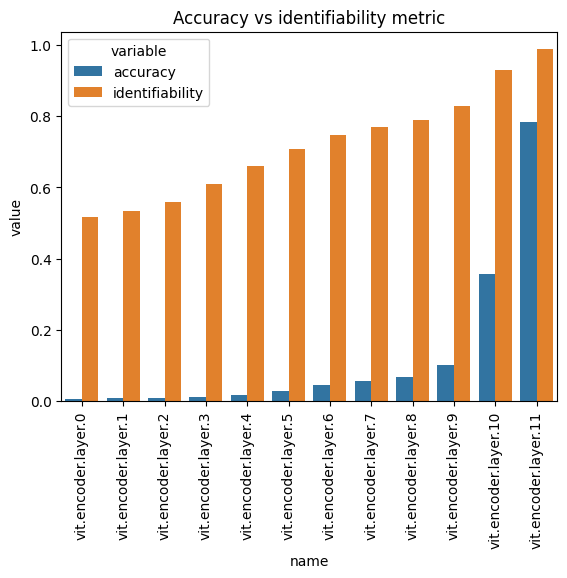

In [7]:
sns.barplot(identifiabilityResults.melt(id_vars='name'), x='name', y='value', hue='variable')
plt.title('Accuracy vs identifiability metric')
_= plt.xticks(rotation=90)


## Causal effect:

Next, verify the impact of CLS token shuffling within the model.

In [8]:
randomized_accuracy = run_across_layers(model, ds, accuracy_random_CLS, 'vit.encoder.layer.{ind}', 12)

100%|███████████████████████████████████████████| 79/79 [01:01<00:00,  1.28it/s]


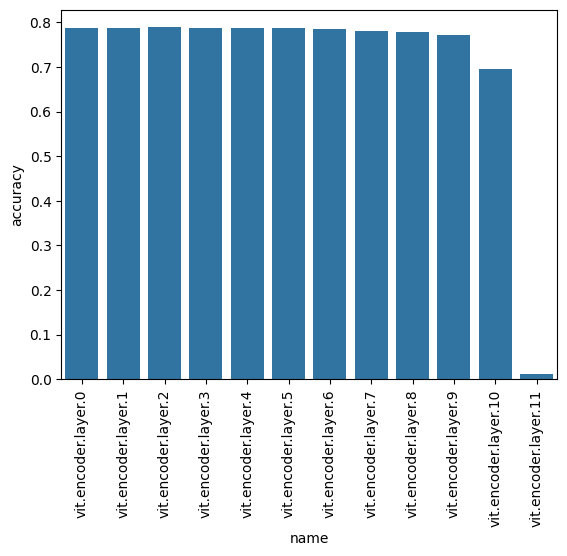

In [9]:
sns.barplot(randomized_accuracy, x='name', y='accuracy')
_= plt.xticks(rotation=90)

#### Double check the hooks

In [10]:
print("Hooks after")
for name, module in model.named_modules():
    if hasattr(module, '_forward_hooks') and module._forward_hooks:
        print(f"Module: {name}, _forward_hooks: {list(module._forward_hooks.keys())}")
    if hasattr(module, '_backward_hooks') and module._backward_hooks:
        print(f"Module: {name}, _backward_hooks: {list(module._backward_hooks.keys())}")


Hooks after


## Linear probes

Per-layer linear probe to decode outputs from CLS tokens

In [12]:
linear_probe_accuracy = run_across_layers(model, ds, linear_probe_by_ridge_regression, 'vit.encoder.layer.{ind}', 12)

100%|███████████████████████████████████████████| 79/79 [01:19<00:00,  1.01s/it]


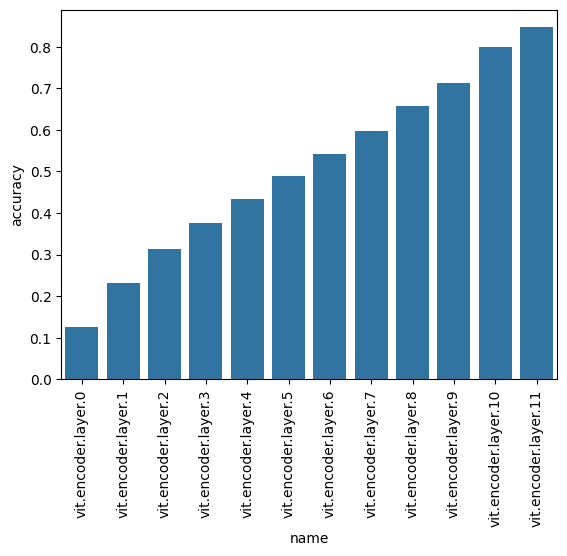

In [15]:
sns.barplot(linear_probe_accuracy, x='name', y='accuracy')
_= plt.xticks(rotation=90)

Probe accuracy smoothly accumulates, as expected. This probe accuracy is higher than the trained model's. That may be a result of data leakage, or it could be a sign of poor initialization (remember that this is a probe-only model).